In [1]:
!pip install gcm-filters
!pip install xrft==0.3.0

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40257")
client

<Client: 'tcp://127.0.0.1:40257' processes=8 threads=64, memory=235.96 GiB>

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:40257' processes=0 threads=0, memory=0 B>

In [4]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import rotate
from xgcm.grid import Grid
import gcm_filters
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [6]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36'])

In [7]:
orca01w = cat.ORCA36(region='1',datatype='interior_daily', season='fma'
                    ).to_dask().isel(deptht=slice(None,-1),depthv=slice(None,-1),depthu=slice(None,-1),
                                     y=slice(None,450)
                                    ).chunk({'y':200,'x':200,'deptht':10,'depthw':10,
                                             'depthv':10,'depthu':10})
orca01s = cat.ORCA36(region='1',datatype='interior_daily', season='aso'
                    ).to_dask().isel(deptht=slice(None,-1),depthv=slice(None,-1),depthu=slice(None,-1),
                                     y=slice(None,450)
                                    ).chunk({'y':200,'x':200,'deptht':10,'depthw':10,
                                             'depthv':10,'depthu':10})
orca01_grid = cat.ORCA36(region='1',datatype='grid',grid='meshmask'
                        ).to_dask().isel(time_counter=0,nav_lev=slice(None,46),y=slice(None,450))
orca01w

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 46, depthu: 46, depthv: 46, depthw: 47, time_counter: 89, x: 361, y: 450)
Coordinates:
  * deptht                (deptht) float32 0.5058 1.556 2.668 ... 856.7 947.4
  * depthu                (depthu) float32 0.5058 1.556 2.668 ... 856.7 947.4
  * depthv                (depthv) float32 0.5058 1.556 2.668 ... 856.7 947.4
  * depthw                (depthw) float32 0.0 1.024 2.103 ... 814.1 901.1 995.7
    nav_lat               (y, x) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2014-02-01T12:00:00 ....
    time_instant          (time_counter) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds, x, y
Data variables: (12/22)
    deptht_bounds         (deptht, axis_nbounds) float32 dask.array<chunksize=(10, 2), meta=np.ndarray>
    depthu_bounds         (depthu, axis_nbounds) float32 dask.array<chunksize=(10, 2), meta=np.ndarray>
    depthv_bounds         (depthv, axis_nbounds) float32 dask.array<chunksize=(10, 2), meta=np.ndarray>
    depthw_bounds         (depthw, axis_nbounds) float32 dask.array<chunksize=(10, 2), meta=np.ndarray>
    difvho                (time_counter, depthw, y, x) float32 dask.array<chunksize=(2, 10, 200, 200), meta=np.ndarray>
    e3t                   (time_counter, deptht, y, x) float32 dask.array<chunksize=(2, 10, 200, 200), meta=np.ndarray>
    ...                    ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    time_instant_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    uo                    (time_counter, depthu, y, x) float32 dask.array<chunksize=(2, 10, 200, 200), meta=np.ndarray>
    vo                    (time_counter, depthv, y, x) float32 dask.array<chunksize=(2, 10, 200, 200), meta=np.ndarray>
    wo                    (time_counter, depthw, y, x) float32 dask.array<chunksize=(2, 10, 200, 200), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.6
    NCO:                       "4.6.2"
    description:               ocean T grid variables
    history:                   Wed Jun 23 15:18:24 2021: ncks -O -F -d deptht...
    nco_openmp_thread_number:  1
    title:                     ocean T grid variables
    uuid:                      d5c5d033-89d4-49e9-9626-748d94a29c1f

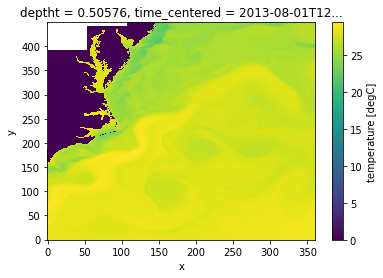

In [19]:
orca01s.thetao.isel(time_counter=0,deptht=0).plot()

<xarray.DataArray 'tmask' (nav_lev: 46, y: 450, x: 361)>
dask.array<getitem, shape=(46, 450, 361), dtype=int8, chunksize=(46, 450, 361), chunktype=numpy.ndarray>
Coordinates:
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 773.4 856.7 947.4
    time_counter  float64 0.0
Dimensions without coordinates: y, x


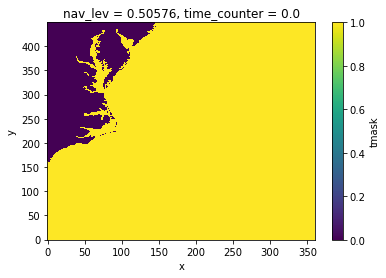

In [28]:
print(orca01_grid.tmask)
orca01_grid.tmask.isel(nav_lev=0).plot()

In [8]:
filter_scale = 30000   # 30 km

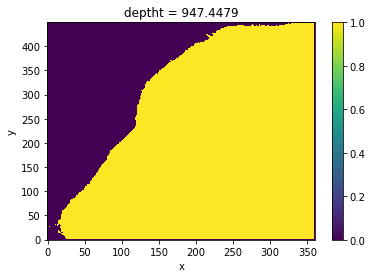

In [9]:
wet_mask = xr.DataArray(np.zeros_like(orca01w.thetao.isel(time_counter=0)),
                        dims=['deptht','y','x'],
                        coords={'deptht':orca01w.deptht,
                                'y':np.arange(len(orca01w.y)),
                                'x':np.arange(len(orca01w.x))}
           )
wet_mask[:,1:-1,1:-1] = orca01_grid.tmask[:,1:-1,1:-1].data.astype(np.float64)

wet_mask.isel(deptht=-1).plot()

In [10]:
ww = xr.DataArray(.5*(orca01w.wo.isel(depthw=slice(1,None)).fillna(0.).data 
                      + orca01w.wo.isel(depthw=slice(None,-1)).fillna(0.).data
                     ),
                  dims=['time_counter','deptht','y','x'],
                  coords={'time_counter':orca01w.time_counter.data, 'deptht':orca01w.deptht,
                          'y':np.arange(len(orca01w.y)),
                          'x':np.arange(len(orca01w.x))}
                 ).chunk({'deptht':10})


In [11]:
grav = 9.81
w_path = f'{SCRATCH}/region01/ORCA36/'+f'sigma0_fma.zarr'
sig0w = xr.open_zarr(gcs.get_mapper(w_path)).sig0



bw = -xr.DataArray(sig0w.isel(deptht=slice(None,-1)).where(xr.DataArray(orca01_grid.tmask.data,
                                                                    dims=['deptht','y','x'])!=0.).data,
                   dims=['time_counter','deptht','y','x'],
                   coords={'time_counter':orca01w.time_counter.data, 'deptht':orca01w.deptht,
                           'y':np.arange(len(orca01w.y)),
                           'x':np.arange(len(orca01w.x))}

bs

,Array,Chunk
Bytes,5.12 GiB,24.79 MiB
Shape,"(92, 46, 450, 361)","(2, 10, 450, 361)"
Count,1293 Tasks,230 Chunks
Type,float64,numpy.ndarray


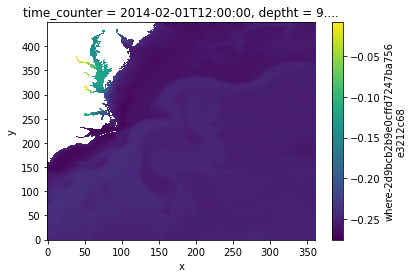

In [58]:
bw.isel(time_counter=0,deptht=7,y=slice(None,450)).plot()

In [12]:
z10 = 7    # grid index of ~10m depth
nMLDw = z10 + np.abs((sig0w.isel(deptht=slice(z10,-1)).fillna(0.)
                      - sig0w.isel(deptht=z10).fillna(0.)
                     ) - .03).reset_coords(drop=True).argmin(dim='deptht').compute()  # indexing needs loading
MLDw = (xr.ones_like(sig0w.isel(deptht=slice(None,-1))) 
        * orca01w.deptht).reset_coords(drop=True)[{'deptht':nMLDw}] 


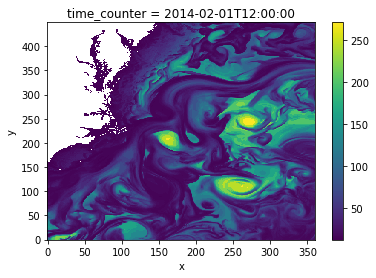

In [13]:
MLDw.isel(time_counter=0).where(MLDw.isel(time_counter=0)>11.).plot()

In [14]:
tmp_path = f'{SCRATCH}/region01/ORCA36/'+f'MLD_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
MLDw.reset_coords(drop=True).chunk({'y':200,'x':160}).to_dataset(name='MLD').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/ORCA36/MLD_fma.zarr


In [15]:
nMLDs = z10 + np.abs((sig0s.isel(deptht=slice(z10,-1)).fillna(0.)
                      - sig0s.isel(deptht=z10).fillna(0.)
                     ) - .03).reset_coords(drop=True).argmin(dim='deptht').compute()  # indexing needs loading
MLDs = (xr.ones_like(sig0s.isel(deptht=slice(None,-1))) 
        * orca01w.deptht).reset_coords(drop=True)[{'deptht':nMLDs}]  
# del nMLDs
MLDs

<xarray.DataArray (time_counter: 92, y: 450, x: 361)>
dask.array<reshape, shape=(92, 450, 361), dtype=float64, chunksize=(92, 450, 361), chunktype=numpy.ndarray>
Coordinates:
    deptht        (time_counter, y, x) float64 13.99 13.99 13.99 ... 30.87 30.87
  * time_counter  (time_counter) datetime64[ns] 2013-08-01T12:00:00 ... 2013-...
Dimensions without coordinates: y, x

In [16]:
tmp_path = f'{SCRATCH}/region01/ORCA36/'+f'MLD_aso.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
MLDs.reset_coords(drop=True).chunk({'y':200,'x':160}).to_dataset(name='MLD').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/ORCA36/MLD_aso.zarr


In [64]:
MLDw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/ORCA36/MLD_fma.zarr")).MLD
MLDs = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/ORCA36/MLD_aso.zarr")).MLD

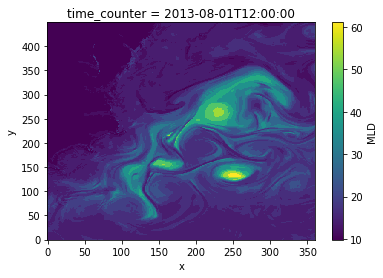

In [65]:
MLDs.isel(time_counter=0).where(MLDs.isel(time_counter=0)>11.).plot()

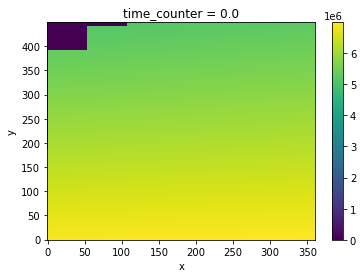

In [17]:
area = (orca01_grid.e1t * orca01_grid.e2t)

area.plot()

In [18]:
dxw = xr.DataArray(orca01_grid.e1u.data, dims=['y','x'],
                   coords={'y':np.arange(len(orca01w.y)),
                           'x':np.arange(len(orca01w.x))}
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(orca01_grid.e2u.data, dims=['y','x'],
                   coords={'y':np.arange(len(orca01w.y)),
                           'x':np.arange(len(orca01w.x))}
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(orca01_grid.e1v.data, dims=['y','x'],
                   coords={'y':np.arange(len(orca01w.y)),
                           'x':np.arange(len(orca01w.x))}
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(orca01_grid.e2v.data, dims=['y','x'],
                   coords={'y':np.arange(len(orca01w.y)),
                           'x':np.arange(len(orca01w.x))}
                  ) # y-spacing centered at southern cell edge
dxw

<xarray.DataArray 'getitem-a4e47f4932be77d7edaad6b719ff9129' (y: 450, x: 361)>
dask.array<getitem, shape=(450, 361), dtype=float64, chunksize=(450, 361), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 441 442 443 444 445 446 447 448 449
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359 360

In [19]:
dx_min = min(orca01_grid.e1u.where(orca01_grid.e1u>0.).min(['y','x'],skipna=True), 
             orca01_grid.e2u.where(orca01_grid.e2u>0.).min(['y','x'],skipna=True),
             orca01_grid.e1v.where(orca01_grid.e1v>0.).min(['y','x'],skipna=True), 
             orca01_grid.e2v.where(orca01_grid.e2v>0.).min(['y','x'],skipna=True)
            )
dx_min = dx_min.values
dx_min

array(2163.97858951)

In [20]:
kappa_w = xr.zeros_like(wet_mask)
kappa_w[:,1:-1,1:-1] += 1.
kappa_s = xr.zeros_like(wet_mask)
kappa_s[:,1:-1,1:-1] += 1.

In [22]:
filter_30km = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'y':-1,'x':-1}), 
        'dxw': dxw.chunk({'y':-1,'x':-1}), 'dyw': dyw.chunk({'y':-1,'x':-1}), 
        'dxs': dxs.chunk({'y':-1,'x':-1}), 'dys': dys.chunk({'y':-1,'x':-1}), 
        'area': area.chunk({'y':-1,'x':-1}), 
        'kappa_w': kappa_w.chunk({'y':-1,'x':-1}), 'kappa_s': kappa_s.chunk({'y':-1,'x':-1})
    }
)
filter_30km

Filter(filter_scale=30000, dx_min=array(2163.97858951), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=16, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

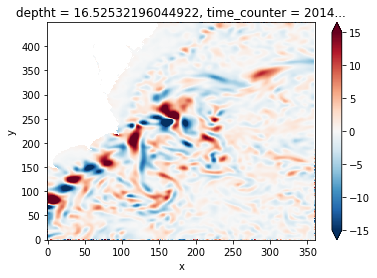

In [23]:
ww_filtered_to_30km = filter_30km.apply(ww.chunk({'y':-1,'x':-1}), dims=['y', 'x'])

(ww_filtered_to_30km.where(xr.DataArray(orca01_grid.tmask.data,
                                        dims=['deptht','y','x'])!=0.).isel(time_counter=0,deptht=10)
 * 86400).plot(vmax=15,vmin=-15,cmap='RdBu_r')

/tmp/ipykernel_4821/54773408.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axs[0].pcolor(orca01w.nav_lon.where(xr.DataArray(orca01_grid.tmask[0].data,
/tmp/ipykernel_4821/54773408.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[1].pcolor(orca01w.nav_lon.where(xr.DataArray(orca01_grid.tmask[0].data,
/tmp/ipykernel_4821/54773408.py:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated sinc

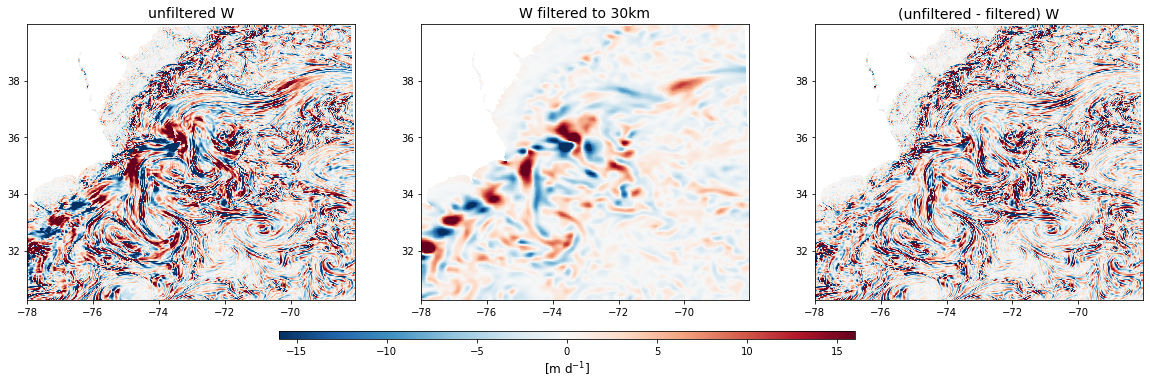

In [25]:
vmin = -16
vmax = 16

fig, axs = plt.subplots(1,3,figsize=(20,6))

im = axs[0].pcolor(orca01w.nav_lon.where(xr.DataArray(orca01_grid.tmask[0].data,
                                        dims=['y','x'])!=0.).isel(y=slice(1,-1),x=slice(1,-1)), 
                  orca01w.nav_lat.where(xr.DataArray(orca01_grid.tmask[0].data,
                                        dims=['y','x'])!=0.).isel(y=slice(1,-1),x=slice(1,-1)),
                  (ww.where(xr.DataArray(orca01_grid.tmask.data,
                                         dims=['deptht','y','x'])!=0.)*86400).isel(time_counter=0, deptht=10,
                                          y=slice(1,-1),x=slice(1,-1)), 
                vmin=vmin, vmax=vmax, 
                cmap='RdBu_r', 
#                   cbar_kwargs={'label': r'm d$^{-1}$'},
                  rasterized=True
)
axs[0].set_title('unfiltered W', fontsize=14)

axs[1].pcolor(orca01w.nav_lon.where(xr.DataArray(orca01_grid.tmask[0].data,
                                        dims=['y','x'])!=0.).isel(y=slice(1,-1),x=slice(1,-1)), 
                  orca01w.nav_lat.where(xr.DataArray(orca01_grid.tmask[0].data,
                                        dims=['y','x'])!=0.).isel(y=slice(1,-1),x=slice(1,-1)),
                  (ww_filtered_to_30km.where(xr.DataArray(orca01_grid.tmask.data,
                                        dims=['deptht','y','x'])!=0.).isel(time_counter=0,deptht=10,
                                                    y=slice(1,-1),x=slice(1,-1))*86400), 
                vmin=vmin, vmax=vmax, 
                cmap='RdBu_r', 
#                   cbar_kwargs={'label': r'm d$^{-1}$'}
                  rasterized=True
)
axs[1].set_title('W filtered to 30km', fontsize=14)

axs[2].pcolor(orca01w.nav_lon.where(xr.DataArray(orca01_grid.tmask[0].data,
                                        dims=['y','x'])!=0.).isel(y=slice(1,-1),x=slice(1,-1)), 
                  orca01w.nav_lat.where(xr.DataArray(orca01_grid.tmask[0].data,
                                        dims=['y','x'])!=0.).isel(y=slice(1,-1),x=slice(1,-1)),
                  ((ww.where(xr.DataArray(orca01_grid.tmask.data,
                                        dims=['deptht','y','x'])!=0.).isel(time_counter=0,deptht=10) 
                    - ww_filtered_to_30km.where(xr.DataArray(orca01_grid.tmask.data,
                                        dims=['deptht','y','x'])!=0.).isel(time_counter=0,deptht=10)
                   )*86400).isel(y=slice(1,-1),x=slice(1,-1)), 
                vmax=vmax, vmin=vmin,
                cmap='RdBu_r', 
#                   cbar_kwargs={'label': r'm d$^{-1}$'}
                  rasterized=True
)
axs[2].set_title(r'(unfiltered - filtered) W', fontsize=14);

fig.subplots_adjust(bottom=0.24, hspace=.25)
cbaxes = fig.add_axes([0.3, 0.15, 0.4, 0.018]) 
cbar = fig.colorbar(im, orientation='horizontal', cax=cbaxes,
#                     ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m d$^{-1}$]', fontsize=12)

plt.savefig('/home/jovyan/Figures/ORCA01-30km_wp_Feb-01.pdf')

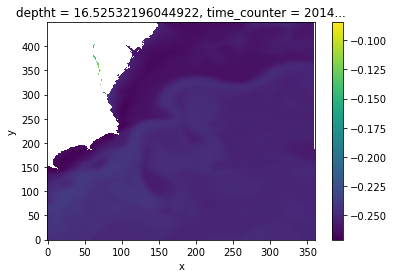

In [26]:
bw_filtered_to_30km = filter_30km.apply(bw.chunk({'y':-1,'x':-1}), dims=['y', 'x'])

(bw_filtered_to_30km.where(xr.DataArray(orca01_grid.tmask.data,
                                        dims=['deptht','y','x'])!=0.).isel(time_counter=0,deptht=10)).plot()

/tmp/ipykernel_4821/3703984680.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axs[0].pcolor(orca01w.nav_lon.where(xr.DataArray(orca01_grid.tmask[0].data,
/tmp/ipykernel_4821/3703984680.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[1].pcolor(orca01w.nav_lon.where(xr.DataArray(orca01_grid.tmask[0].data,
/tmp/ipykernel_4821/3703984680.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecate

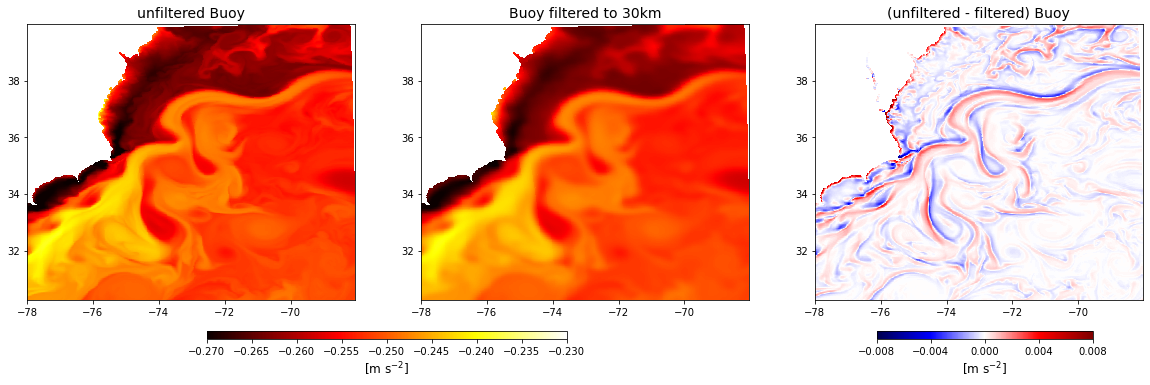

In [27]:
vmin = -.27
vmax = -.23

fig, axs = plt.subplots(1,3,figsize=(20,6))

im = axs[0].pcolor(orca01w.nav_lon.where(xr.DataArray(orca01_grid.tmask[0].data,
                                        dims=['y','x'])!=0.).isel(y=slice(1,-1),x=slice(1,-1)), 
                   orca01w.nav_lat.where(xr.DataArray(orca01_grid.tmask[0].data,
                                        dims=['y','x'])!=0.).isel(y=slice(1,-1),x=slice(1,-1)),
                       (bw).isel(time_counter=0,deptht=10,y=slice(1,-1),x=slice(1,-1)), 
                vmin=vmin, vmax=vmax, 
                cmap='hot', 
                       rasterized=True
)
axs[0].set_title(r'unfiltered Buoy', fontsize=14)

axs[1].pcolor(orca01w.nav_lon.where(xr.DataArray(orca01_grid.tmask[0].data,
                                        dims=['y','x'])!=0.).isel(y=slice(1,-1),x=slice(1,-1)), 
              orca01w.nav_lat.where(xr.DataArray(orca01_grid.tmask[0].data,
                                        dims=['y','x'])!=0.).isel(y=slice(1,-1),x=slice(1,-1)),
              bw_filtered_to_30km.isel(time_counter=0,deptht=10,
                          y=slice(1,-1),x=slice(1,-1)), 
                vmin=vmin, vmax=vmax, 
                cmap='hot', 
                  rasterized=True
)
axs[1].set_title(r'Buoy filtered to 30km', fontsize=14)

im2 = axs[2].pcolor(orca01w.nav_lon.where(xr.DataArray(orca01_grid.tmask[0].data,
                                        dims=['y','x'])!=0.).isel(y=slice(1,-1),x=slice(1,-1)), 
                    orca01w.nav_lat.where(xr.DataArray(orca01_grid.tmask[0].data,
                                        dims=['y','x'])!=0.).isel(y=slice(1,-1),x=slice(1,-1)),
                    (bw.isel(time_counter=0,deptht=10) 
                     - bw_filtered_to_30km.isel(time_counter=0,deptht=10)
                    ).isel(y=slice(1,-1),x=slice(1,-1)), 
                        vmax=.008, vmin=-.008,
                        cmap='seismic', 
                      rasterized=True
)
axs[2].set_title(r'(unfiltered - filtered) Buoy', fontsize=14);

fig.subplots_adjust(bottom=0.24, hspace=.25)
cbaxes = fig.add_axes([0.25, 0.15, 0.25, 0.018]) 
cbar = fig.colorbar(im, orientation='horizontal', cax=cbaxes,
#                     ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m s$^{-2}$]', fontsize=12)
cbaxes = fig.add_axes([0.715, 0.15, 0.15, 0.018]) 
cbar = fig.colorbar(im2, orientation='horizontal', cax=cbaxes,
                    ticks=[-.008,-.004,0.,.004,.008]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m s$^{-2}$]', fontsize=12)

plt.savefig('/home/jovyan/Figures/ORCA01-30km_bp_Feb-01.pdf')

In [28]:
wpbpw = ((((ww - ww_filtered_to_30km
           ) * (bw - bw_filtered_to_30km
               )
          ).where(xr.DataArray(orca01_grid.tmask[0].data,
                               dims=['y','x'])!=0.) * xr.DataArray(orca01_grid.e3t_0.data, 
                                                                   dims=['deptht','y','x'])
         ).where(orca01w.deptht.isel(deptht=slice(None,-1)) <= MLDw
                ).isel(y=slice(1,-1),x=slice(1,-1)).sum('deptht',skipna=True) 
         / MLDw.isel(y=slice(1,-1),x=slice(1,-1)))
wpbpw

<xarray.DataArray (time_counter: 89, y: 448, x: 359)>
dask.array<truediv, shape=(89, 448, 359), dtype=float64, chunksize=(2, 200, 199), chunktype=numpy.ndarray>
Coordinates:
  * y             (y) int64 1 2 3 4 5 6 7 8 ... 441 442 443 444 445 446 447 448
  * x             (x) int64 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * time_counter  (time_counter) datetime64[ns] 2014-02-01T12:00:00 ... 2014-...
    deptht        (time_counter, y, x) float64 61.11 86.93 133.1 ... 53.85 53.85

In [29]:
tmp_path = f'{SCRATCH}/region01/ORCA36/'+f'wb-30km_z0-MLD_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
wpbpw.reset_coords(drop=True).chunk({'y':200,'x':160}).to_dataset(name='wpbp').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/ORCA36/wb-30km_z0-MLD_fma.zarr


/tmp/ipykernel_4821/178892655.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(orca01w.nav_lon.where(xr.DataArray(orca01_grid.tmask[0].data,


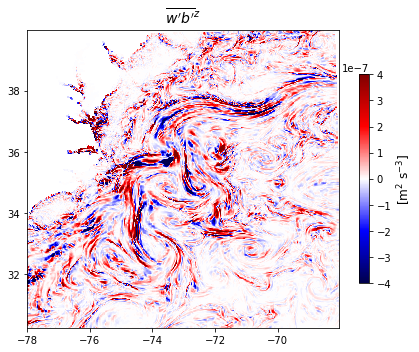

In [30]:
wpbpw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/ORCA36/wb_z0-MLD_fma.zarr")).wpbp

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
im = ax.pcolor(orca01w.nav_lon.where(xr.DataArray(orca01_grid.tmask[0].data,
                                        dims=['y','x'])!=0.).isel(y=slice(1,-1),x=slice(1,-1)), 
                    orca01w.nav_lat.where(xr.DataArray(orca01_grid.tmask[0].data,
                                        dims=['y','x'])!=0.).isel(y=slice(1,-1),x=slice(1,-1)),
                  wpbpw.isel(time_counter=0).where(xr.DataArray(orca01_grid.tmask[0].isel(y=slice(1,-1),x=slice(1,-1)).data,
                                                                dims=['y','x'])!=0.),
                  vmin=-4e-7, vmax=4e-7,
                  cmap='seismic', rasterized=True
)

ax.set_title(r"$\overline{w'b'}^z$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)

plt.savefig('/home/jovyan/Figures/ORCA01-30km_wpbpz_Feb-01.pdf')

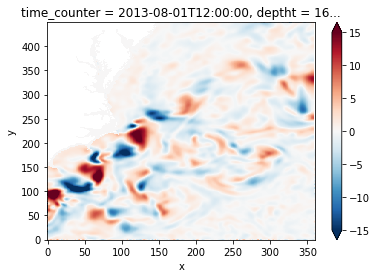

In [31]:
ws_filtered_to_30km = filter_30km.apply(ws.chunk({'y':-1,'x':-1}), dims=['y', 'x'])

(ws_filtered_to_30km.where(xr.DataArray(orca01_grid.tmask[0].data,
                                        dims=['y','x'])!=0.).isel(time_counter=0,deptht=10)
 * 86400).plot(vmax=15,vmin=-15,cmap='RdBu_r')

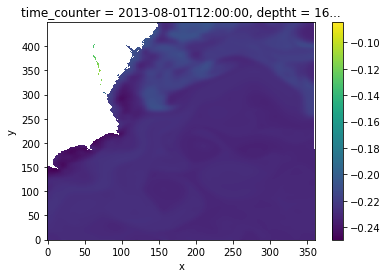

In [32]:
bs_filtered_to_30km = filter_30km.apply(bs.chunk({'y':-1,'x':-1}), dims=['y', 'x'])

(bs_filtered_to_30km.where(xr.DataArray(orca01_grid.tmask[0].data,
                                        dims=['y','x'])!=0.).isel(time_counter=0,deptht=10)).plot()

In [33]:
wpbps = ((((ws - ws_filtered_to_30km
           ) * (bs - bs_filtered_to_30km
               )
          ).where(xr.DataArray(orca01_grid.tmask[0].data,
                               dims=['y','x'])!=0.) * xr.DataArray(orca01_grid.e3t_0.data, 
                                                                   dims=['deptht','y','x'])
         ).where(orca01s.deptht.isel(deptht=slice(None,-1)) <= MLDs
                ).isel(y=slice(1,-1),x=slice(1,-1)).sum('deptht',skipna=True) 
         / MLDs.isel(y=slice(1,-1),x=slice(1,-1)))
wpbps

<xarray.DataArray (time_counter: 92, y: 448, x: 359)>
dask.array<truediv, shape=(92, 448, 359), dtype=float64, chunksize=(2, 200, 199), chunktype=numpy.ndarray>
Coordinates:
  * y             (y) int64 1 2 3 4 5 6 7 8 ... 441 442 443 444 445 446 447 448
  * x             (x) int64 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * time_counter  (time_counter) datetime64[ns] 2013-08-01T12:00:00 ... 2013-...
    deptht        (time_counter, y, x) float64 13.99 13.99 13.99 ... 30.87 35.74

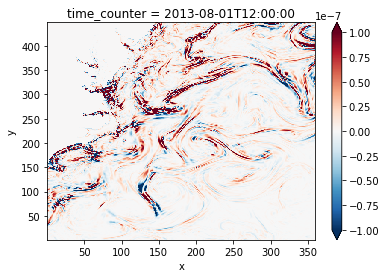

In [94]:
wpbps.isel(time_counter=0).plot(vmax=1e-7)

In [34]:
tmp_path = f'{SCRATCH}/region01/ORCA36/'+f'wb-30km_z0-MLD_aso.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
wpbps.reset_coords(drop=True).chunk({'y':200,'x':160}).to_dataset(name='wpbp').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/ORCA36/wb-30km_z0-MLD_aso.zarr
